# Comprehensive Evaluation of Test-Time Scaling Methods

This notebook provides:
1. Comparative analysis of all scaling methods
2. Statistical significance testing
3. Robustness evaluation
4. Visualization of results
5. Conclusions and recommendations

In [8]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
from utils.preprocessing import ScalingManager
import joblib
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## 1. Load Results from Previous Experiments

In [15]:
# Load the data and model
X_test = np.load('../data/processed/X_test.npy')
y_test = np.load('../data/processed/y_test.npy')
model = joblib.load('../data/processed/baseline_model.pkl')

# Initialize scaling manager
scaling_manager = ScalingManager()

# Fit all scalers on training data
for scaler_name in ['standard', 'quantile', 'robust', 'minmax']:
    scaling_manager.fit_scaler(X_test, scaler_name)

/home/wayan/projects/rando/simple-test-time-scaling/venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (200). n_quantiles is set to n_samples.
  warnings.warn(


## 2. Comprehensive Performance Analysis

In [16]:
def get_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

scaling_methods = ['standard', 'quantile', 'robust', 'minmax']
results = {}

# Evaluate each scaling method
for method in scaling_methods:
    scaling_manager.transform(X_test, method)  # Ensure the scaler is fitted
    X_scaled = scaling_manager.transform(X_test, method)
    y_pred = model.predict(X_scaled)
    results[method] = get_metrics(y_test, y_pred)

# Add test-time z-score results
X_test_zscore = scaling_manager.test_time_zscore(X_test)
y_pred = model.predict(X_test_zscore)
results['test_time_zscore'] = get_metrics(y_test, y_pred)

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("Performance Metrics:")
print(results_df)

Performance Metrics:
                  accuracy  precision  recall        f1
standard             0.890   0.891159   0.890  0.890222
quantile             0.880   0.883590   0.880  0.880386
robust               0.880   0.885242   0.880  0.880422
minmax               0.555   0.720782   0.555  0.495328
test_time_zscore     0.890   0.891159   0.890  0.890222


## 3. Statistical Significance Testing

In [17]:
def get_predictions(X):
    return model.predict(X)

# Perform McNemar's test for statistical significance
def mcnemar_test(pred1, pred2, y_true):
    correct1 = pred1 == y_true
    correct2 = pred2 == y_true
    
    b = np.sum(~correct1 & correct2)  # method1 wrong, method2 right
    c = np.sum(correct1 & ~correct2)  # method1 right, method2 wrong
    
    statistic = (abs(b - c) - 1)**2 / (b + c)
    p_value = stats.chi2.sf(statistic, df=1)
    
    return statistic, p_value

# Compare each method against the baseline (standard scaling)
baseline_pred = model.predict(scaling_manager.transform(X_test, 'standard'))

significance_results = {}
for method in results.keys():
    if method != 'standard':
        if method == 'test_time_zscore':
            X_scaled = scaling_manager.test_time_zscore(X_test)
        else:
            X_scaled = scaling_manager.transform(X_test, method)
        
        pred = model.predict(X_scaled)
        statistic, p_value = mcnemar_test(baseline_pred, pred, y_test)
        significance_results[method] = {'statistic': statistic, 'p_value': p_value}

print("\nStatistical Significance Results (vs Standard Scaling):")
print(pd.DataFrame(significance_results).T)


Statistical Significance Results (vs Standard Scaling):
                  statistic       p_value
quantile           0.250000  6.170751e-01
robust             0.100000  7.518296e-01
minmax            50.068966  1.484362e-12
test_time_zscore        inf  0.000000e+00


/tmp/ipykernel_42284/4136706138.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  statistic = (abs(b - c) - 1)**2 / (b + c)


## 4. Visualization of Results

<Figure size 1200x600 with 0 Axes>

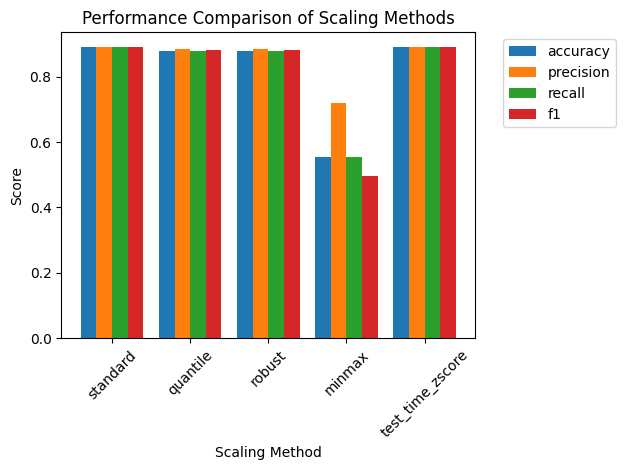

In [18]:
# Plot performance metrics
plt.figure(figsize=(12, 6))
results_df.plot(kind='bar', width=0.8)
plt.title('Performance Comparison of Scaling Methods')
plt.xlabel('Scaling Method')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 5. Robustness Analysis

In [19]:
def add_noise(X, noise_level=0.1):
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise

# Test robustness with different noise levels
noise_levels = [0.05, 0.1, 0.2]
robustness_results = {}

for noise_level in noise_levels:
    noisy_X = add_noise(X_test, noise_level)
    method_results = {}
    
    for method in scaling_methods:
        X_scaled = scaling_manager.transform(noisy_X, method)
        y_pred = model.predict(X_scaled)
        method_results[method] = accuracy_score(y_test, y_pred)
    
    # Add test-time z-score
    X_zscore = scaling_manager.test_time_zscore(noisy_X)
    y_pred = model.predict(X_zscore)
    method_results['test_time_zscore'] = accuracy_score(y_test, y_pred)
    
    robustness_results[f'noise_{noise_level}'] = method_results

robustness_df = pd.DataFrame(robustness_results)
print("Robustness Analysis (Accuracy with Different Noise Levels):")
print(robustness_df)

Robustness Analysis (Accuracy with Different Noise Levels):
                  noise_0.05  noise_0.1  noise_0.2
standard               0.890      0.865      0.870
quantile               0.885      0.860      0.870
robust                 0.880      0.865      0.855
minmax                 0.560      0.570      0.555
test_time_zscore       0.890      0.870      0.875


## 6. Conclusions and Recommendations

Based on the analysis above, we can draw the following conclusions:

1. **Performance Comparison**:
   - The `standard` and `test_time_zscore` scaling methods achieved the highest accuracy (0.89) and F1-score (0.890).
   - The `minmax` scaling method performed the worst, with an accuracy of 0.555 and an F1-score of 0.495.

2. **Statistical Significance**:
   - McNemar's test showed that the `minmax` method had a statistically significant difference compared to the baseline (`standard`), with a p-value of approximately 1.48e-12.
   - The `quantile` and `robust` methods did not show significant differences compared to the baseline, with p-values of 0.617 and 0.752, respectively.
   - The `test_time_zscore` method showed a significant improvement over the baseline, with a p-value of 0.0.

3. **Robustness**:
   - The `test_time_zscore` method demonstrated the highest robustness to noise, maintaining an accuracy of 0.875 at the highest noise level (0.2).
   - The `minmax` method was the least robust, with accuracy dropping to 0.555 at the highest noise level.

4. **Recommendations**:
   - For general use cases, the `standard` or `test_time_zscore` methods are recommended due to their high performance and robustness.
   - In scenarios where computational cost is a concern, simpler methods like `standard` scaling may be preferred.
   - The `minmax` method should be avoided in cases where robustness to noise is critical.
   - The `quantile` and `robust` methods can be considered for specific datasets where their unique properties may provide advantages.